In [1]:
# This jupyter notebook is used to plot Figure 5 in Model 1
# Required packages: numpy, matplotlib
# conda create --name myproject python=3.9
# conda activate myproject
# conda install numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt

鉴于阅读本项目的很多同学可能对数学建模不太熟悉，故我在这里讲解一下微分方程建模的求解方法，以下内容均为我的个人理解，纯手码无AI，有任何问题欢迎在项目里提issue进行交流。对于熟悉这部分内容的同学可以直接跳过即可。

## 欧拉法求解微分方程
所有微分方程的数学建模问题，在建立完成微分方程组之后，就可以使用欧拉法来离散化求解，用于**模拟**微分方程组所描述的数学问题。

欧拉法是一种非常常见的微分方程数值解法，核心思路就是将微分方程离散化，不断迭代就可以绘制出微分方程的动态图像。

例如，对于如下的一个微分方程：
$$
    \frac{\mathbf{d}y}{\mathbf{d}t} = f(t)
$$
为了便于理解，可以想象$y$是种群数量（下文提到“种群数量”则将其理解为这个式子中的$y$即可），左侧一阶导理解为“变化速率”，右侧的$f(t)$用于描述种群数量在时刻$t$的变化情况。将一阶导离散化，可以表示为：
$$
    \frac{\Delta y}{\Delta t} = f(t) 
$$
将上面$\Delta$变化量展开可以表示为：
$$
    \frac{y_{n+1} - y_n}{t_{n+1} - t_{n}} = f(t)
$$
推导上面式子可以得到种群数量的迭代公式：
$$
    y_{n+1} = f(t)(t_{n+1} - t_{n}) + y_n
$$
根据上面这个式子我们就可以得到种群数量的迭代求解公式。通过这个式子我想说明以下几点：
1. 对于微分方程类的问题而言，我们所谓的**数学建模**，其实就是需要设计一个合适的位于右侧的$f(t)$函数，可以用于描述我们关心的变量$y$关于时间的变化情况
2. 要计算下一时刻点的种群数量$y_{n+1}$，需要知道右侧的所有内容，包括三个部分：$f(t)$、$(t_{n+1}-t_n)$、$y_n$，其中：
    - $f(t)$是我们设计出来的函数，也就是数学建模的目标，在计算时这个函数已知；
    - $(t_{n+1}-t_n)$是一个时间步长，在算法中其实就是下一次for循环，根本就不需要在意。通过调其他参数把这个时间尺度调整到可解释的范围即可；
    - $y_n$是上一个时刻点的种群数量，也就是上一次刚计算出来的结果。意味着我们只需要有一个初值$y_0$，那么就可以根据$f(t)$来模拟出整个种群变化的迭代过程。因此，这个种群数量的初值$y_0$也是一个需要我们手动调整的参数。


在了解了这部分内容之后，可以去阅读我的[中文博客文章](https://www.cnblogs.com/JQ-Luke/p/18858431)，其中关于模型一的思路、原理和公式推导部分。比赛中遇到的问题本质上也只是需要设计一个合适的$f(t)$而已，不过可能涉及到更多变量，从而建立成一个微分方程组。在读完之后可以继续阅读下面代码。

下面代码是我在赛中，配合Claude3.5辅助写出来的，主要分为两部分，先是参数的设置，然后是欧拉法求解并绘图。

In [ ]:
# Figure 5. The result of FENCM
# 参数设置

# Define parameters
k = 3  # number of trophic levels
r = 0.1  # Increased growth rate (was 0.15)
gamma = np.array([0.01, 0.2, 0.05, 0.3])  # Decreased death rate for N0 (was 0.05)
alpha = np.array([0.02, 0.05, 0.03])  # Decreased predation rate on N0 (was 0.25)
beta = np.array([0.015, 0.04, 0.015])  # conversion efficiency
d = 0.2  # decomposition rate
delta = 0.12  # decomposer conversion efficiency
gamma_D = 0.5  # decomposer death rate

# Time parameters
t_max = 60
dt = 0.01 
t = np.arange(0, t_max, dt)
n_steps = len(t)

# Initialize arrays for storing results
N = np.zeros((k+1, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)

# Initial conditions
N[:, 0] = [10, 3, 2, 1]
N_org[0] = 5
N_D[0] = 100
N_inorg[0] = 50

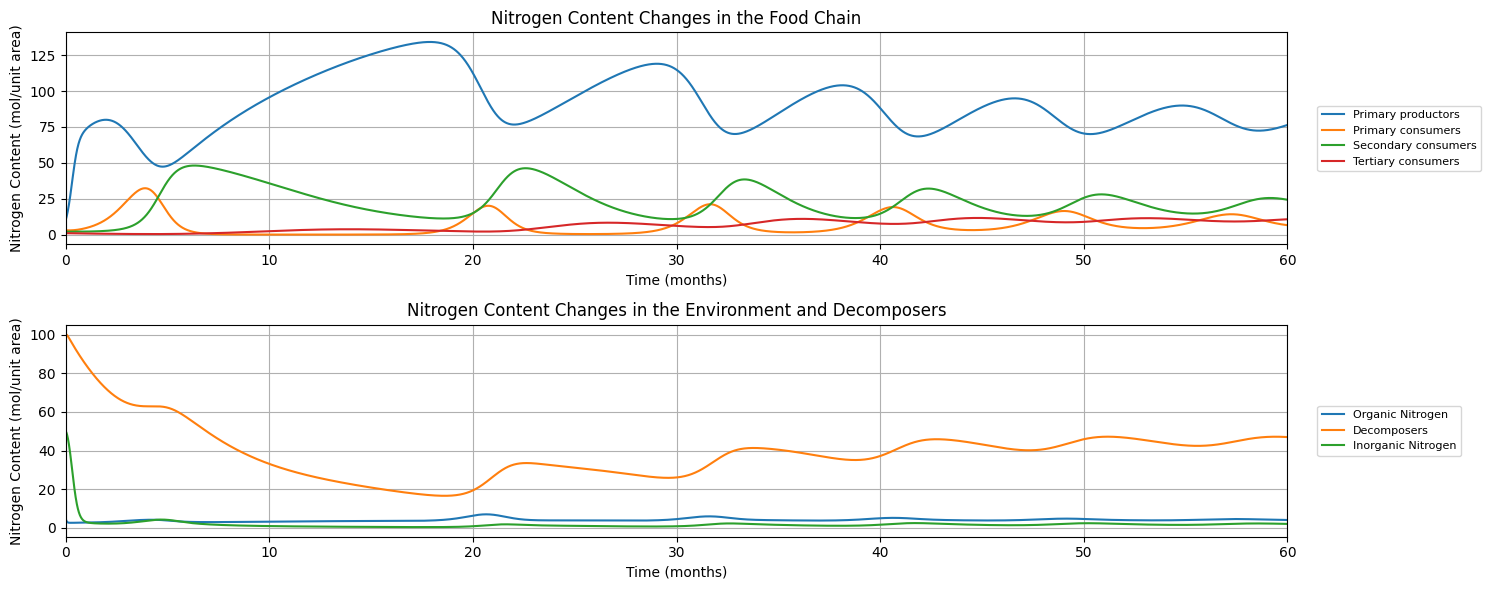

In [2]:
# Euler method for solving the system
# 使用欧拉法迭代来求解微分方程，并绘制图像

# for循环在每个时间步长上迭代，轮迭代中更新所有变量
for i in range(n_steps-1): 
    # Trophic levels 各营养级的氮含量
    N[0, i+1] = N[0, i] + dt * (r * N_inorg[i] * N[0, i] - gamma[0] * N[0, i] - alpha[0] * N[0, i] * N[1, i])
    
    for j in range(1, k):
        N[j, i+1] = N[j, i] + dt * (beta[j-1] * N[j-1, i] * N[j, i] - gamma[j] * N[j, i] - 
                                   alpha[j] * N[j, i] * N[j+1, i])
    
    N[k, i+1] = N[k, i] + dt * (beta[k-1] * N[k-1, i] * N[k, i] - gamma[k] * N[k, i])
    
    # Organic nitrogen 有机氮计算
    transfer_sum = sum((alpha[j] - beta[j]) * N[j, i] * N[j+1, i] for j in range(k))
    mortality_sum = sum(gamma[j] * N[j, i] for j in range(k+1))
    
    N_org[i+1] = N_org[i] + dt * (transfer_sum + mortality_sum + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers 分解者计算
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    
    # Inorganic nitrogen 无机氮计算
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - r * N_inorg[i] * N[0, i])


plt.figure(figsize=(15, 6))

# 绘制营养级
# plot trophic levels
plt.subplot(2, 1, 1)
plt.xlim(0, t_max)  # Limit x-axis to actual data range

plt.plot(t, N[0], label=f'Primary productors')
plt.plot(t, N[1], label=f'Primary consumers')
plt.plot(t, N[2], label=f'Secondary consumers')
plt.plot(t, N[3], label=f'Tertiary consumers')
plt.title('Nitrogen Content Changes in the Food Chain')
plt.xlabel('Time (months)')
plt.ylabel('Nitrogen Content (mol/unit area)')
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Position legend outside plot
plt.grid(True)

# 将有机氮、分解者和无机氮绘制在同一个图中
# plot organic nitrogen, decomposers, and inorganic nitrogen
plt.subplot(2, 1, 2)
plt.xlim(0, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen')
plt.plot(t, N_D, label='Decomposers')
plt.plot(t, N_inorg, label='Inorganic Nitrogen')
plt.title('Nitrogen Content Changes in the Environment and Decomposers')
plt.xlabel('Time (months)')
plt.ylabel('Nitrogen Content (mol/unit area)')
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Position legend outside plot
plt.grid(True)

plt.tight_layout()
plt.show()